In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets.fashion_mnist import load_data
from matplotlib import pyplot as plt
import numpy as np

import warnings
import IPython.display as display # for inspecting the images by displaying them in the kernel
import random # for the random seed used as input for the generator
from numpy.random import choice
import time # time the execution of codeblocks
from IPython.display import FileLink, FileLinks

import os, glob, gc # for managing files/directories
kernel_start = time.time()
LIMIT = 8

In [25]:
# load the images into memory
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11493376/11490434 [==============================] - 0s 0us/step


In [26]:
#Function for Generator of GAN
def make_generator_model():
    
    seed = tf.keras.Input(shape=((100,)))

    x = layers.Dense(7*7*256, use_bias=False)(seed)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 256))(x)
    
    x = layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(1, (5,5), strides=(1,1), padding='same', activation='tanh', use_bias=False)(x)
    
    model = tf.keras.Model(inputs=seed, outputs=x)

    return model

generator = make_generator_model()
print(generator.summary())

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_9 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 14, 14, 128)       819200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 14, 128)     

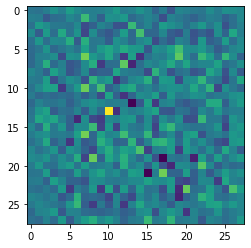

In [27]:
#View a sample image generated by the the generator

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])


In [28]:
#Function for Discriminator of GAN
def make_discriminator_model():
    image = tf.keras.Input(shape=((28,28,1)))
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding = 'same', use_bias=False)(image)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding = 'same', use_bias=False)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    model = tf.keras.Model(inputs = image, outputs = x)
    return model
discriminator = make_discriminator_model()
print(discriminator.summary())

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        1600      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 128)         204800    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 128)       

In [29]:

decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00412213]], shape=(1, 1), dtype=float32)


In [30]:
# Cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [31]:
#Dicriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [32]:
#Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [33]:
#Optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [34]:
checkpoint_dir = '../modelse/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [35]:
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [46]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [53]:
def train(dataset, epochs):
    all_gl = np.array([]); all_dl = np.array([])
    for epoch in range(epochs):
        gl = []; dl = []
        start = time.time()

        for image_batch in dataset:
            gg, dd = train_step(image_batch)
            gl.append(gg); dl.append(dd)

        # To produce images for the GIF
        all_gl = np.append(all_gl,np.array([gl]))
        all_dl = np.append(all_dl,np.array([dl]))
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1,seed)
        plt.figure(figsize=(16,2))
        plt.plot(np.arange(len(gl)),gl,label='Gen_loss')
        plt.plot(np.arange(len(dl)),dl,label='Disc_loss')
        plt.legend()
        plt.title('Epoch '+str(epoch)+' Loss')
        ymax = plt.ylim()[1]
        plt.show()

        # PLOT ALL TIME LOSS
        plt.figure(figsize=(16,2))
        plt.plot(np.arange(len(all_gl)),all_gl,label='Gen_loss')
        plt.plot(np.arange(len(all_dl)),all_dl,label='Disc_loss')
        plt.legend()
        plt.ylim((0,np.min([1.1*np.max(all_gl),2*ymax])))
        plt.title('All Time Loss')
        plt.show()
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  #To generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [56]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('../reports/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

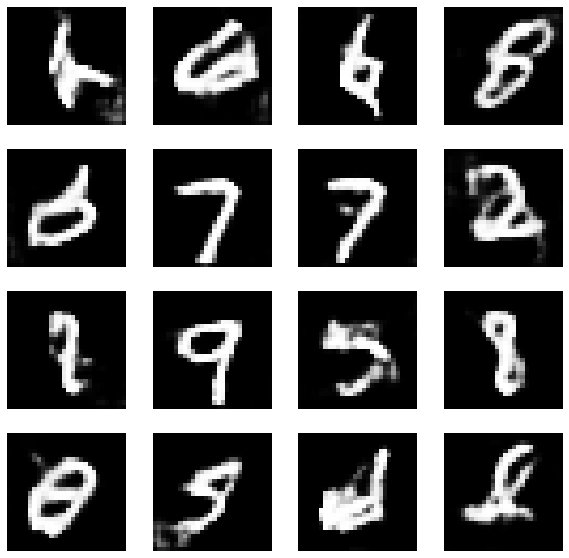

In [57]:
EPOCHS = 50

In [ ]:
train(train_dataset, EPOCHS)

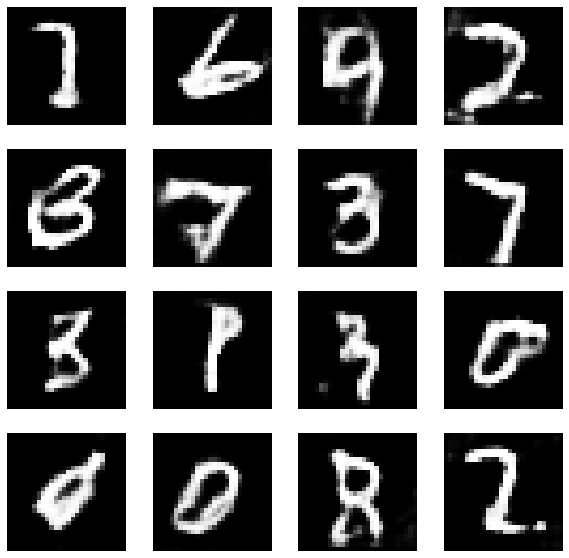

In [65]:
seed1 = tf.random.normal([num_examples_to_generate, 100])
generate_and_save_images(generator, 100, seed1)